# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [1]:
# for linux
!apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# !brew install poppler tesseract libmagic

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
libmagic-dev is already the newest version (1:5.41-3ubuntu0.1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [2]:
%pip install -Uq "unstructured[all-docs]" pillow lxml pillow
%pip install -Uq chromadb tiktoken
%pip install -Uq langchain langchain-community langchain-openai langchain-groq
%pip install -Uq python_dotenv


In [3]:
# import os

# # keys for the services we will use

# os.environ["OPENAI_API_KEY"] = "sk-..."
# os.environ["GROQ_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_API_KEY"] = "sk-..."
# os.environ["LANGCHAIN_TRACING_V2"] = "true"


In [4]:
import os
import sys
from google.colab import userdata

running_in_colab = True

if running_in_colab:
    print("Running in Colab. Set API keys manually or through environment.")
    if "OPENAI_API_KEY" not in os.environ:
        os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
    if "GROQ_API_KEY" not in os.environ:
        os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
    if "LANGCHAIN_API_KEY" not in os.environ:
        os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
    os.environ["LANGCHAIN_TRACING_V2"] = "true"  # Enable tracing for both envs

# Access environment variables
openai_api_key = os.getenv("OPENAI_API_KEY")
groq_api_key = os.getenv("GROQ_API_KEY")
langchain_api_key = os.getenv("LANGCHAIN_API_KEY")
langchain_tracing = os.getenv("LANGCHAIN_TRACING_V2", "false")

# Validate required keys
required_keys = {
    "OPENAI_API_KEY": openai_api_key,
    "GROQ_API_KEY": groq_api_key,
    "LANGCHAIN_API_KEY": langchain_api_key
}

missing = [k for k, v in required_keys.items() if not v]
if missing:
    raise EnvironmentError(f"Missing required API keys: {', '.join(missing)}")

print("✅ Environment ready!")

Running in Colab. Set API keys manually or through environment.
✅ Environment ready!


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [ ]:
from unstructured.partition.pdf import partition_pdf

# /content/1706.03762v7.pdf
output_path = "/content/"
file_path = output_path + '1706.03762v7.pdf'

# you can see here we did not use the loader from langchain

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True,            # extract tables
    strategy="hi_res",                     # mandatory to infer tables

    extract_image_block_types=["Image", "Table"],   # Add 'Table' to list to extract image of tables
    # image_output_dir_path=output_path,   # if None, images and tables will saved in base64

    extract_image_block_to_payload=True,   # Note: if true, will extract base64 for API usage

    chunking_strategy="by_title",          # or 'basic'
    max_characters=10000,                  # defaults to 500
    combine_text_under_n_chars=2000,       # defaults to 0
    new_after_n_chars=6000,

    # extract_images_in_pdf=True,          # deprecated
)


The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [6]:
len(chunks)

12

In [7]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [8]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

chunks[3].metadata.orig_elements

In [9]:
# This is what an extracted image looks like.
# base64 is important cause we would send it through API
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True

elements = chunks[3].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '44e0ea9c-38e0-4267-aefb-b6e232982037',
 'text': '',
 'metadata': {'coordinates': {'points': ((np.float64(486.0),
     np.float64(261.1805555555558)),
    (np.float64(486.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(614.7805555555556)),
    (np.float64(664.0), np.float64(261.1805555555558))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-06-17T06:28:37',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFiALIDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJ

### Separate extracted elements into tables, text, and images

In [10]:
from unstructured.documents.elements import Table, CompositeElement

In [11]:
# separate tables from texts
tables = []
texts = []

# old version - now the unstructured have been updated
# for chunk in chunks:
#     if "Table" in str(type(chunk)):
#         tables.append(chunk)

#     if "CompositeElement" in str(type((chunk))):
#         texts.append(chunk)

# new version of code
for chunk in chunks:
    if "CompositeElement" in str(type(chunk)):  # Check if it's a CompositeElement
        for element in chunk.metadata.orig_elements:  # Iterate through its elements
            if "Table" in str(type(element)):  # Now check for Table type
                tables.append(element)  # Append the table element
        texts.append(chunk)  # Still append the CompositeElement to texts

In [12]:
for i, chunk in enumerate(chunks):
    print(f"Metadata: {vars(chunk.metadata)}")

Metadata: {'filetype': 'application/pdf', 'languages': ['eng'], 'last_modified': '2025-06-17T06:28:37', 'page_number': 1, 'orig_elements': [<unstructured.documents.elements.Text object at 0x7f635ee7ff50>, <unstructured.documents.elements.Text object at 0x7f63ec67cd10>, <unstructured.documents.elements.Text object at 0x7f63e92238d0>, <unstructured.documents.elements.Text object at 0x7f63ead05d10>, <unstructured.documents.elements.Text object at 0x7f63e64bf0d0>, <unstructured.documents.elements.Header object at 0x7f63e63a5ad0>, <unstructured.documents.elements.Text object at 0x7f635ee4e110>, <unstructured.documents.elements.Text object at 0x7f63eacedf10>, <unstructured.documents.elements.Text object at 0x7f63e6626e50>, <unstructured.documents.elements.Title object at 0x7f63e63a4c10>, <unstructured.documents.elements.Title object at 0x7f63e5e84c50>, <unstructured.documents.elements.Title object at 0x7f635f85d690>, <unstructured.documents.elements.Title object at 0x7f63e6627510>, <unstruct

In [13]:
len(chunks)

12

In [14]:
tables

In [15]:
texts

In [16]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

In [58]:
images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

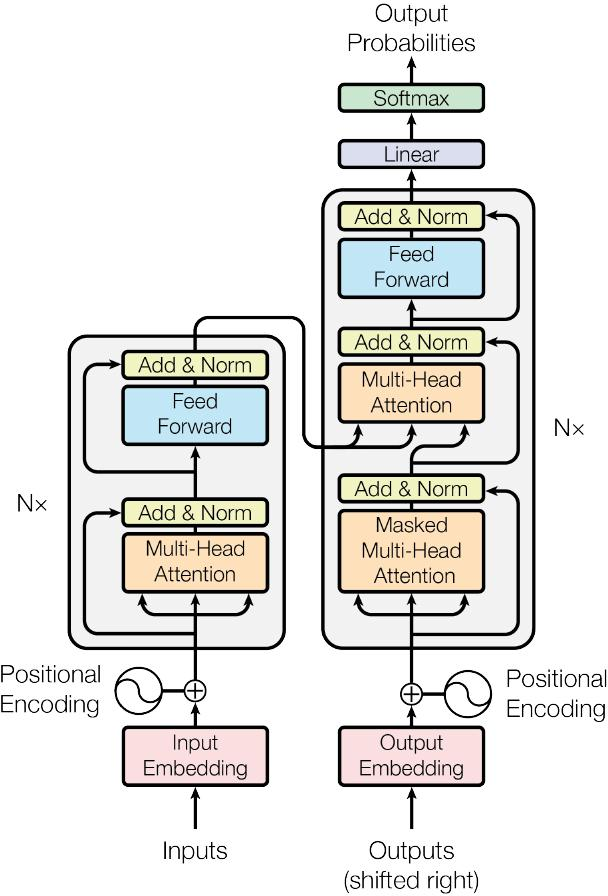

In [57]:
import base64
from IPython.display import Image, display

def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))

display_base64_image(images[0])

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [18]:
%pip install -Uq langchain-groq
%pip install -Uq langchain_openai

In [19]:
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [20]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
# model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
model = ChatOpenAI(temperature=0.5, model="gpt-4o-mini")

# Output parser
parser = StrOutputParser()

# Chain
summarize_chain = {"element": lambda x: x} | prompt | model | parser

In [21]:
texts[0].metadata.orig_elements

In [22]:
# Summarize text
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [23]:
text_summaries

['The paper introduces the Transformer, a new network architecture for sequence transduction that relies solely on attention mechanisms, eliminating the need for recurrent or convolutional networks. It demonstrates superior performance in machine translation tasks, achieving a BLEU score of 28.4 for English-to-German and 41.8 for English-to-French, outperforming previous models while requiring less training time. The Transformer also shows versatility by successfully applying to English constituency parsing with varying training data sizes. The authors contributed equally, with various roles in design, implementation, and evaluation of the model.',
 'Recurrent neural networks, particularly long short-term memory and gated recurrent networks, are established as leading methods for sequence modeling and transduction tasks like language modeling and machine translation. However, their sequential nature limits parallelization and efficiency, especially with longer sequences. Attention mech

In [24]:
table_summaries

['The table compares different layer types in terms of complexity, sequential operations, and maximum path length. Self-Attention has a complexity of O(n? - d) with O(1) sequential operations and a maximum path length of O(1). Recurrent layers have a complexity of O(n - d?), O(n) sequential operations, and a maximum path length of O(n). Convolutional layers have a complexity of O(k-n-d?), O(1) sequential operations, and a maximum path length of O(logx(n)). Restricted Self-Attention has a complexity of O(r-n-d), unspecified sequential operations, and a maximum path length of O(n/r).',
 'The table presents various translation models along with their performance metrics in English-German (EN-DE) and English-French (EN-FR) translations, including BLEU scores, training costs, and computational costs (FLOPs). Key models include ByteNet with a BLEU score of 23.75, GNMT + RL achieving 24.6 (EN-DE) and 39.92 (EN-FR), and the Transformer (big) model with the highest EN-DE score of 28.4 and EN-FR

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [25]:
# %pip install -Uq langchain_openai

In [26]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the transformers
                  architecture. Be specific about graphs, such as bar plots."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [27]:
image_summaries

['The image is a schematic representation of the transformer architecture, illustrating the flow of data and operations involved in processing input sequences to produce output probabilities.\n\n### Layout and Components:\n\n1. **Inputs and Outputs**:\n   - At the bottom, the diagram starts with "Inputs," which are represented as a box labeled "Input Embedding." \n   - To the right, there is an "Output Embedding," which connects to "Outputs (shifted right)." This signifies that the outputs are aligned with a right-shifted version of the input sequence, crucial for tasks like language modeling.\n\n2. **Positional Encoding**:\n   - Both the input and output sections are integrated with "Positional Encoding," shown as circles connecting to the embeddings. This indicates the importance of position in sequential data.\n\n3. **N Layers**:\n   - The architecture consists of several stacked layers, indicated by "Nx." This shows that multiple identical layers are used, a key feature of transfor

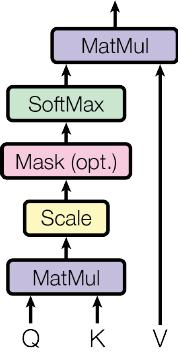

In [28]:
display_base64_image(images[1])

In [29]:
print(image_summaries[1])

The image displays a flow diagram illustrating key components of the transformer architecture, specifically focusing on operations related to the attention mechanism.

1. **Nodes**: The diagram features several labeled boxes stacked vertically:
   - At the top, there is a box labeled "MatMul" (short for matrix multiplication). It is highlighted in purple.
   - Below that, another box labeled "SoftMax" is shown in green.
   - Below the SoftMax, there’s a pink box labeled "Mask (opt.)", indicating an optional masking operation.
   - Next, a yellow box labeled "Scale" follows.
   - The bottom of the diagram has another "MatMul" box in purple, indicating another matrix multiplication operation.

2. **Connections**: 
   - Arrows point downward from the top "MatMul" box to the "SoftMax" box, then to the "Mask (opt.)" box, which, in turn, connects to the "Scale" box. 
   - The "Mask (opt.)" box also connects back to the earlier "MatMul" box, indicating a conditional flow based on whether the 

## Load data and summaries to vectorstore

### Create the vectorstore

In [30]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
# from langchain.embeddings import OpenAIEmbeddings
from langchain_openai import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
# It would be better if we use the other OpenAIEmbeddings
# vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings(model="text-embedding-3-small"))
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

<ipython-input-30-1040950160>:12: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())


### Load the summaries and link the to the original data

In [31]:
[str(uuid.uuid4()) for _ in texts]

['fc0400d0-4ca7-432f-891d-8dc19bc15018',
 '529d43b0-98ca-48ec-a8d1-3b4a6483f19a',
 '0b3cb1ec-4de6-44cd-90f0-522eefb23514',
 '3fd45f37-05e1-4b63-9a8f-cdc0128dc141',
 'cb2fb437-d0ad-4d0b-8e33-6d844ca3f1e7',
 'af85ac8e-1e47-47d7-9cd7-98fa6e1679f1',
 '918dd93c-ca68-46a2-8bb3-7b3842551d28',
 'f4dd8206-54d9-4a75-8e94-f78693af8c18',
 '5afafca9-ca23-4fa8-9e2d-10575d8b984f',
 'ef57f77b-dcd8-4c1c-9d23-13457321d893',
 '5472a37b-e381-4b1a-a84d-e5a7dc1456e6',
 '1c2dfa7c-dfb9-4da3-9eab-56a24bfa5d98']

In [32]:
[str(uuid.uuid4()) for _ in texts]

['d1173135-25b9-4b5c-a16f-d7bcc0554e1c',
 '40bf19f8-088b-4bdd-a13f-67b0c4b9db78',
 '8459e5b8-bc98-40ce-adbd-a09b34d16ebd',
 'dc294b3a-324f-4065-b0b4-d14c2360f6de',
 '6b39d0d9-da52-435d-8307-67b5ee0fd4b3',
 'efa6f55a-db0d-4a9c-bf8c-374c52ffb953',
 'b029153b-45a5-4289-ad49-fad80f246104',
 '8de5d1fb-6e00-4b0a-bf8a-94d4b9cf46d9',
 'e0a02ee9-6417-4137-aae0-599383578257',
 'ec103ae8-cba6-4440-8167-baf6901681db',
 '84a4608b-425a-43f9-ab9f-135aa3be8a4f',
 '06713ec0-a6b8-4450-8483-da747c8e6129']

Note:
- each time run the block of code `[str(uuid.uuid4()) for _ in texts]` we get different result
- So each docs / tables / imgs would have different unique ids BUT the corresponding summaries would be linked to the original sources by that unique ids for later references

In [33]:
# texts[0].metadata.to_dict()

In [34]:
# tables[0].metadata.to_dict()

In [35]:
images

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAOAAmADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK5OTxVqWp6pdWPhjSI75LSQw3N/d3PkW6yjrGpCszsO

In [36]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))



### Check retrieval

In [37]:
# Retrieve
chunks = retriever.invoke(
    "What is the scaled-dot product attention? Also, find for me if there is a visualization of scaled-dot product attention"
)

In [38]:
chunks

 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAIAAU4DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK8S+Ofj658P6toGm6ZKVuraZdSmGSAwUkIhx1B+fI+le2186/HjwxY2Gr6VqpaWe91W8f7RJI3AjURqkagYAAH4nJJNAHv+l6jb6vpVpqVo263uoVmjP+ywyPx5

In [39]:
for chunk in chunks:
    print(str(chunk) + "\n\n" + "-" * 80)

3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention

Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a ma

In [40]:
for i, chunk in enumerate(chunks):
    if "CompositeElement" in str(type(chunk)):
        print("\n\nChunk", i)
        for doc in chunk.metadata.orig_elements:
            print(doc.to_dict()["type"], doc.metadata.page_number)



Chunk 0
Title 3
NarrativeText 3
Footer 3
Title 4
Title 4
Image 4
Image 4
NarrativeText 4
NarrativeText 4
Title 4
NarrativeText 4
NarrativeText 4
Formula 4
NarrativeText 4
NarrativeText 4


In [41]:
chunks[0].metadata.orig_elements[0].to_dict()

{'type': 'Title',
 'element_id': 'c01fabcb-b3a7-43f5-9c6c-78867798eb6f',
 'text': '3.2 Attention',
 'metadata': {'detection_class_prob': 0.8557953834533691,
  'coordinates': {'points': ((np.float64(297.23052978515625),
     np.float64(1892.3127316666664)),
    (np.float64(297.23052978515625), np.float64(1919.9866205555556)),
    (np.float64(475.8683776855469), np.float64(1919.9866205555556)),
    (np.float64(475.8683776855469), np.float64(1892.3127316666664))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-06-17T06:28:37',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 3}}

In [42]:
!pip install --upgrade pymupdf


In [43]:
import fitz
print(fitz.__doc__)

PyMuPDF 1.26.1: Python bindings for the MuPDF 1.26.2 library (rebased implementation).
Python 3.11 running on linux (64-bit).



In [44]:
import fitz  # PyMuPDF
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from PIL import Image

def plot_pdf_with_boxes(pdf_page, segments):
    pix = pdf_page.get_pixmap()
    pil_image = Image.frombytes("RGB", (pix.width, pix.height), pix.samples)

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(pil_image)
    categories = set()

    category_to_color = {
        "Title": "orchid",
        "Image": "forestgreen",
        "Table": "tomato",
    }

    for segment in segments:
        try:
            coords = segment["coordinates"]
            points = coords["points"]
            layout_width = coords["layout_width"]
            layout_height = coords["layout_height"]

            scaled_points = [
                (x * pix.width / layout_width, y * pix.height / layout_height)
                for x, y in points
            ]

            category = segment.get("category", "Text")
            box_color = category_to_color.get(category, "deepskyblue")
            categories.add(category)

            rect = patches.Polygon(
                scaled_points, linewidth=1, edgecolor=box_color, facecolor="none"
            )
            ax.add_patch(rect)
        except Exception as e:
            print(f"[ERROR] Skipping segment: {e}")

    # Add legend
    legend_handles = [patches.Patch(color="deepskyblue", label="Text")]
    for cat in ["Title", "Image", "Table"]:
        if cat in categories:
            legend_handles.append(
                patches.Patch(color=category_to_color[cat], label=cat)
            )

    ax.axis("off")
    ax.legend(handles=legend_handles, loc="upper right")
    plt.tight_layout()
    plt.show()

def render_page(doc_list: list, page_number: int, print_text=True) -> None:
    print(f"[DEBUG] Rendering page {page_number}...")
    pdf_page = fitz.open(file_path).load_page(page_number - 1)

    page_docs = [
        doc for doc in doc_list if doc.metadata.get("page_number") == page_number
    ]

    print(f"[DEBUG] Found {len(page_docs)} elements for page {page_number}")
    segments = [doc.metadata for doc in page_docs]
    print(f"[DEBUG] Drawing {len(segments)} segments...")
    plot_pdf_with_boxes(pdf_page=pdf_page, segments=segments)

    if print_text:
        print("\n[DEBUG] Extracted Text:\n" + "-" * 40)
        for doc in page_docs:
            print(f"{doc.page_content}\n")



In [45]:
from langchain_core.documents import Document
import fitz  # PyMuPDF
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import PIL.Image as Image

# --- Extract page numbers from a chunk ---
def extract_page_numbers_from_chunk(chunk):
    elements = chunk.metadata.orig_elements
    page_numbers = set()
    for element in elements:
        page_numbers.add(element.metadata.page_number)
    return page_numbers

# --- Display elements on pages from a single chunk ---
def display_chunk_pages(chunk):
    page_numbers = extract_page_numbers_from_chunk(chunk)
    docs = []

    for element in chunk.metadata.orig_elements:
        metadata = element.metadata.to_dict()

        # Infer category
        if "Table" in str(type(element)):
            metadata["category"] = "Table"
        elif "Image" in str(type(element)):
            metadata["category"] = "Image"
        else:
            metadata["category"] = "Text"

        metadata["page_number"] = int(element.metadata.page_number)
        docs.append(Document(page_content=element.text, metadata=metadata))

    for page_number in page_numbers:
        render_page(docs, page_number, print_text=False)


In [46]:
# !pip install langchain_unstructured

In [47]:
chunks[0].metadata.orig_elements

In [ ]:
# all_elements = []
# for chunk in chunks:
#     if chunk.metadata.orig_elements:
#         all_elements.extend(chunk.metadata.orig_elements)

# print(f"Collected {len(all_elements)} elements from {len(chunks)} chunks")


[DEBUG] Rendering page 3...
[DEBUG] Found 3 elements for page 3
[DEBUG] Drawing 3 segments...


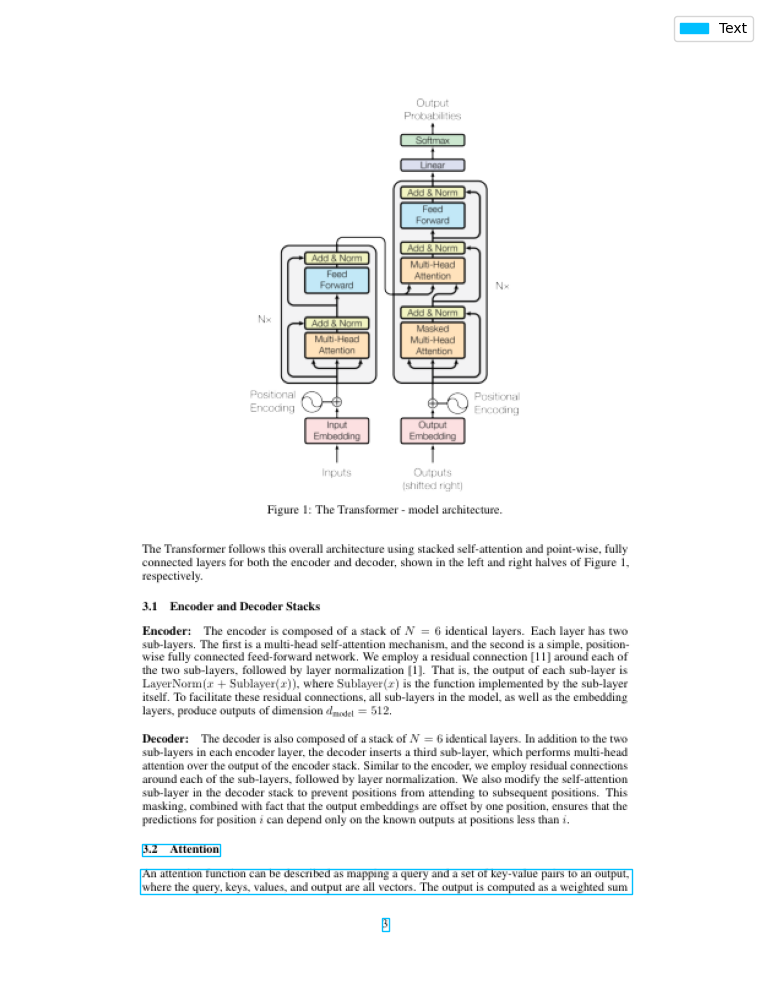

[DEBUG] Rendering page 4...
[DEBUG] Found 12 elements for page 4
[DEBUG] Drawing 12 segments...


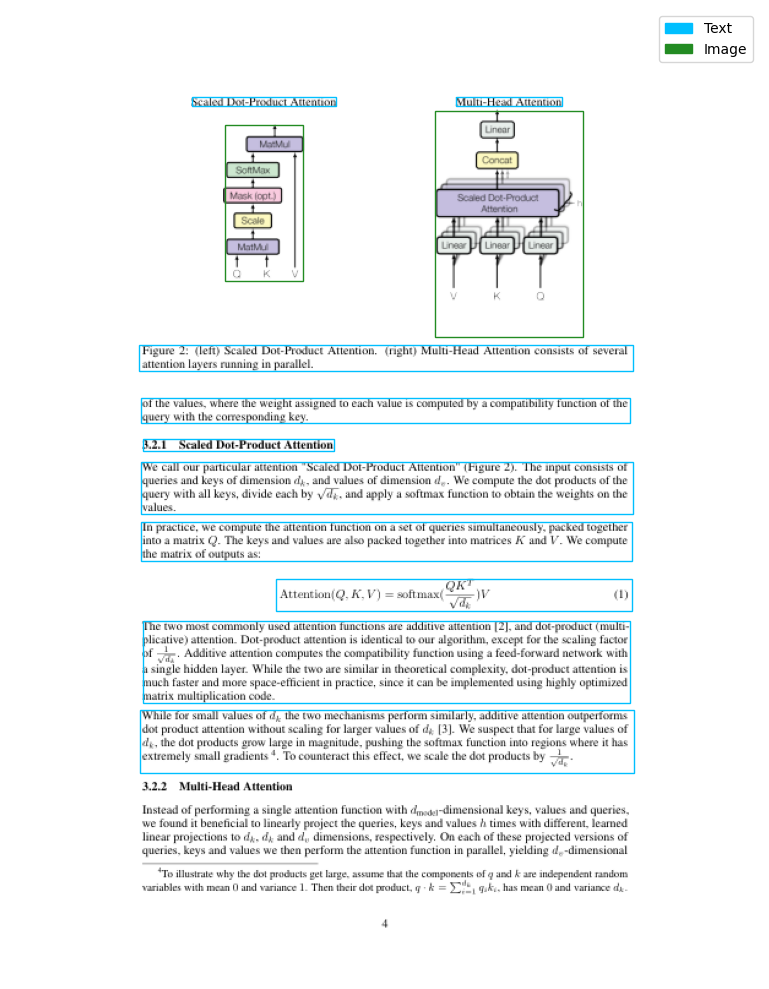

In [49]:
display_chunk_pages(chunks[0])

## RAG pipeline

In [50]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [51]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a process that enables a model to focus on specific parts of the input data while processing it. It maps a query and a set of key-value pairs to an output, where the output is calculated as a weighted sum of the values. The weights reflect the compatibility between the query and the keys. In the context of the Transformer model, attention is primarily implemented using "Scaled Dot-Product Attention" and "Multi-Head Attention."

1. **Scaled Dot-Product Attention**:
   - Inputs consist of queries and keys of dimension \( d_k \), and values of dimension \( d_v \).
   - It computes the dot products of the query with all keys, applies a scaling factor of \( \frac{1}{\sqrt{d_k}} \), and then uses a softmax function to determine the weights on the values.

2. **Multi-Head Attention**:
   - Instead of a single attention function, it projects the queries, keys, and values into multiple subspaces and computes attention in parallel across these subspaces.
   - This mech

In [62]:
response = chain_with_sources.invoke(
    "What do the author mean about 'attention'?"
)

print("Response:", response['response'])


Response: In the provided context, "attention" refers to a mechanism in neural networks that enables the model to focus on specific parts of the input when producing outputs. It involves mapping a query and key-value pairs to compute an output as a weighted sum of the values, where the weights are determined by a compatibility function between the query and the keys. This mechanism helps in capturing long-range dependencies and improving the interpretability of model decisions. The example image illustrates how attention weights are distributed over different words in a sentence, indicating how the model prioritizes certain words when generating a response.


In [60]:
print("\n\nContext:")

for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")




Context:
3.2 Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum

3

Scaled Dot-Product Attention

Multi-Head Attention

Linear

Figure 2: (left) Scaled Dot-Product Attention. (right) Multi-Head Attention consists of several attention layers running in parallel.

of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

3.2.1 Scaled Dot-Product Attention

We call our particular attention "Scaled Dot-Product Attention" (Figure 2). The input consists of queries and keys of dimension dk, and values of dimension dv. We compute the dot products of the √ dk, and apply a softmax function to obtain the weights on the query with all keys, divide each by values.

In practice, we compute the attention function on a set of queries simultaneously, packed togethe

In [59]:
response['context']['images']

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATEBBYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATEBBYDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+iiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoo

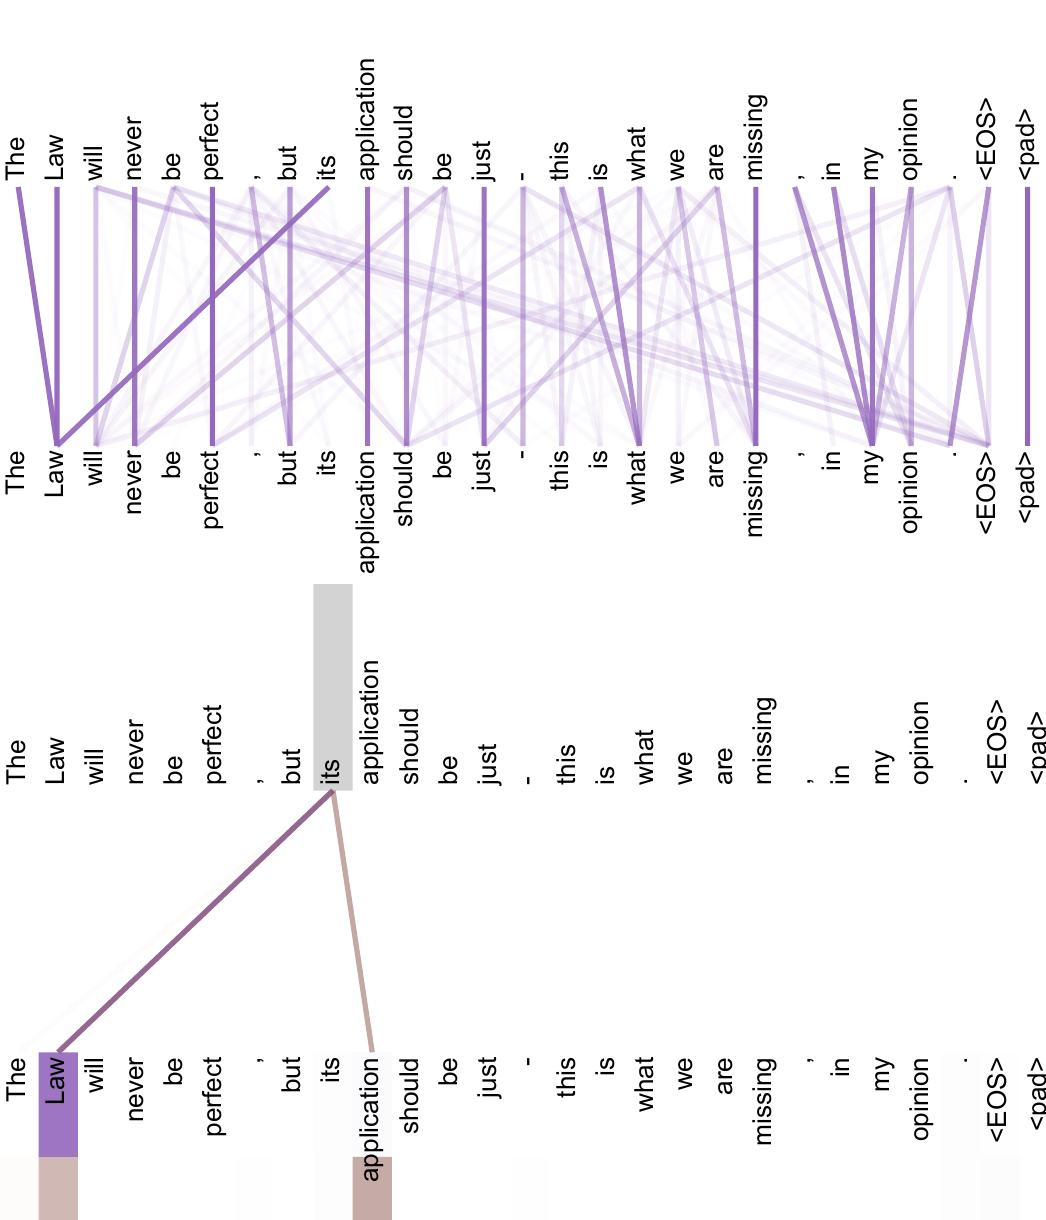

In [61]:
for image in response['context']['images']:
    print(image)
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)